# Load TrainingData

# Viz

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision.transforms.functional import to_tensor
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.files = files
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        mask_path = os.path.join(self.masks_dir, self.files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

        if self.image_transform:
            image = self.image_transform(image)
        
        # Convert mask image to numpy array, then to tensor
        mask = np.array(mask, dtype=np.int32)  # Ensure the mask is an integer array
        mask = torch.from_numpy(mask)  # Convert numpy array to tensor

        return image, mask


# Image and mask transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.ToTensor()

# Set directories and prepare file lists
images_dir = 'Data/Processed/naip_tiles'
masks_dir = 'Data/Processed/lu_tiles'
files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f)) and not (f.endswith('(1).tif') or f.endswith('(2).tif'))]

# Split files into training and validation sets
train_files, val_files = train_test_split(files, test_size=0.20, random_state=42)

# Dataset and DataLoader setup using paths
train_dataset = CustomDataset(images_dir, masks_dir, train_files, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(images_dir, masks_dir, val_files, image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


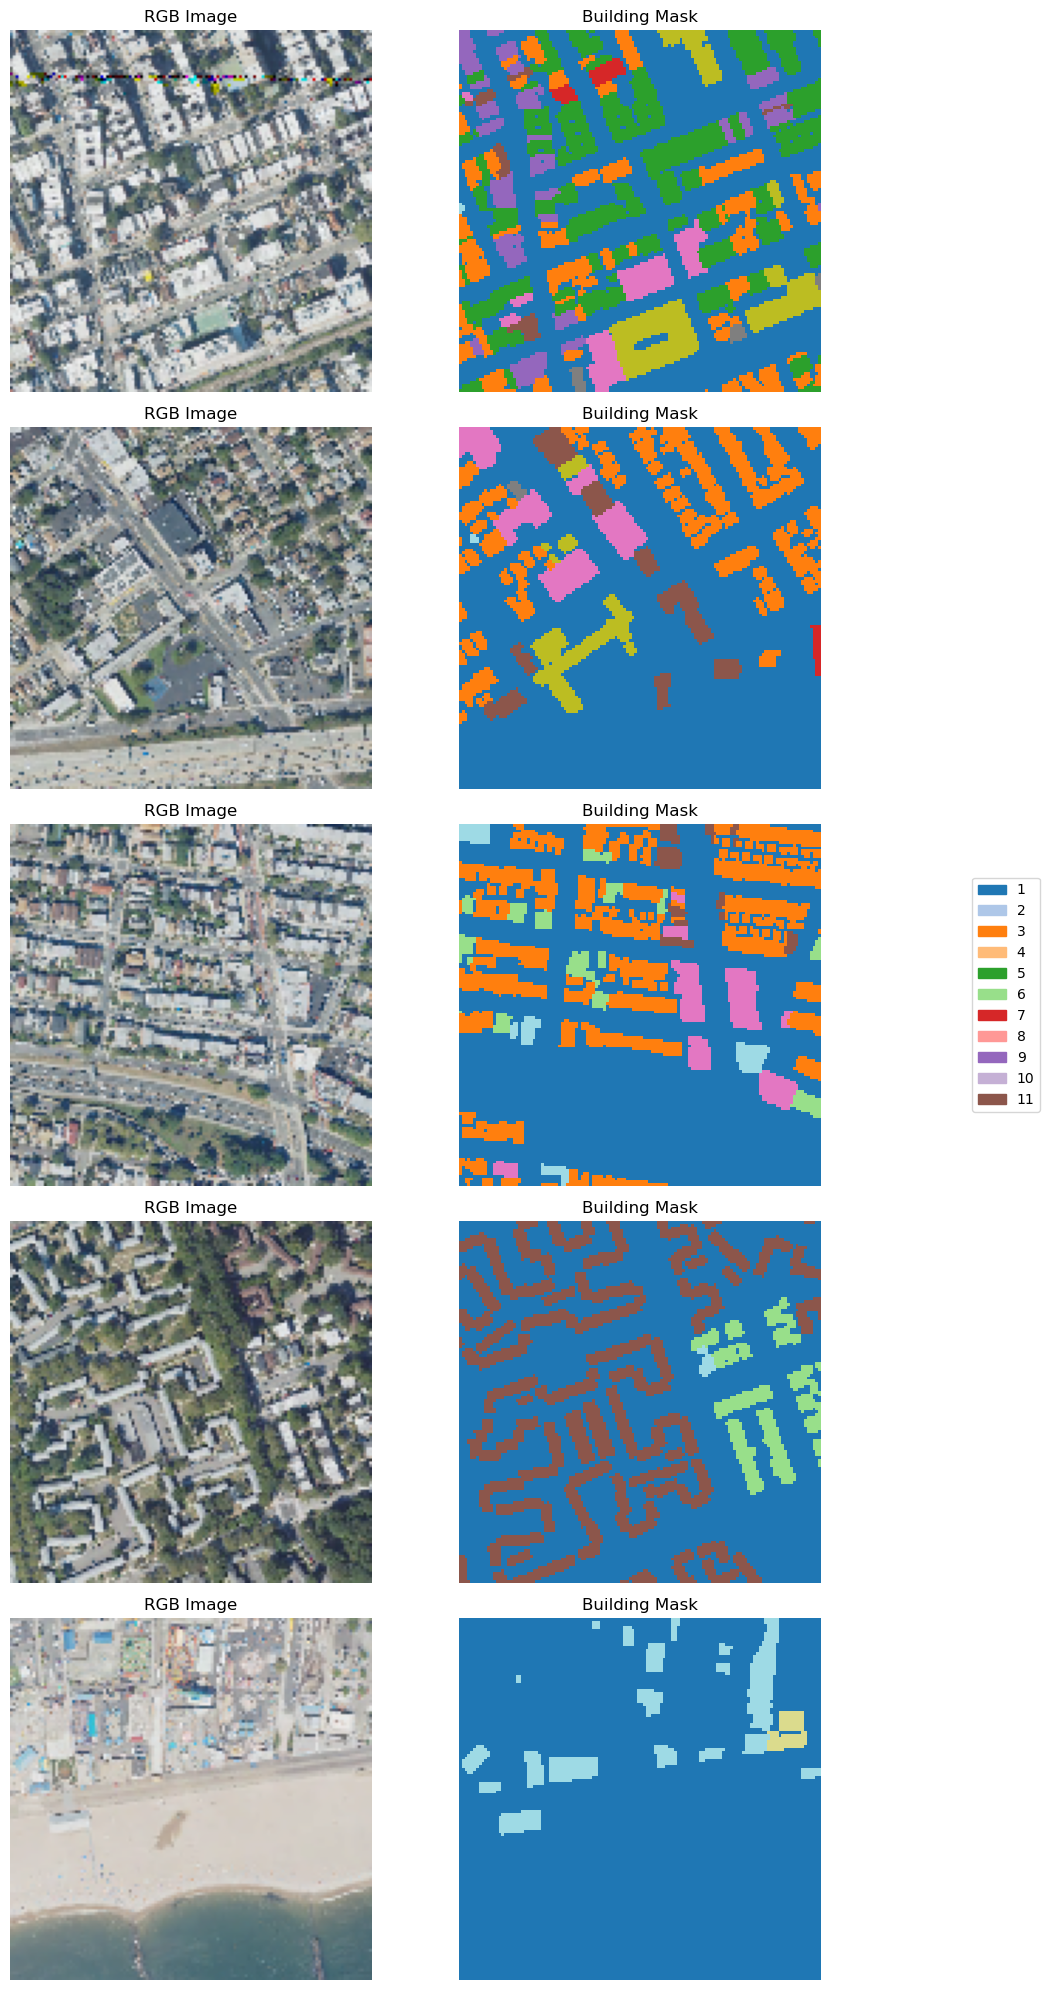

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_images(images, masks, num_images=5, class_labels=None):
    # Define the colormap and create a patch (proxy artist) for every color 
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(len(class_labels))]  # Assuming number of classes doesn't exceed the cmap length
    patches = [mpatches.Patch(color=colors[i], label=class_labels[i]) for i in range(len(class_labels))]

    fig, axs = plt.subplots(num_images, 2, figsize=(10, 20))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        img = img * torch.tensor([0.229, 0.224, 0.225], device=img.device).view(1, 1, 3) + torch.tensor([0.485, 0.456, 0.406], device=img.device).view(1, 1, 3)
        img = img.detach().cpu().numpy()
        mask = masks[i].squeeze().detach().cpu().numpy()

        axs[i, 0].imshow(img.clip(0, 1))  # Clip the values to be in the valid range for imshow
        axs[i, 0].set_title('RGB Image')
        axs[i, 0].axis('off')

        # Display mask with nearest interpolation
        mask_display = axs[i, 1].imshow(mask, cmap='tab20', interpolation='nearest')
        axs[i, 1].set_title('Building Mask')
        axs[i, 1].axis('off')

    # Place a legend outside the rightmost column
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 0.5), loc='center left')

    plt.tight_layout()
    plt.show()

# Class labels (example labels, adjust as necessary)
class_labels = range(1,12)

# Fetch images and masks
for images, masks in train_loader:
    plot_images(images, masks, num_images=5, class_labels=class_labels)
    break  # Only process the first batch


In [4]:
len(train_dataset)

4233

In [5]:
len(val_dataset)

1059

In [6]:
import torch
from collections import defaultdict

def count_labels(dataloader):
    label_counts = defaultdict(int)
    max_label = 0

    for _, masks in dataloader:
        for mask in masks:
            unique_labels = torch.unique(mask)
            for label in unique_labels:
                label_counts[int(label.item())] += 1
                if label.item() > max_label:
                    max_label = label.item()

    return label_counts, max_label

# Calculate label counts and the maximum label in the training data
train_label_counts, train_max_label = count_labels(train_loader)

print("Label counts in training data:", train_label_counts)
print("Maximum label in training data:", train_max_label)


Label counts in training data: defaultdict(<class 'int'>, {0: 4233, 7: 1683, 9: 984, 1: 3343, 2: 2877, 4: 2679, 5: 2473, 8: 2777, 11: 948, 6: 1246, 10: 1548, 3: 1738})
Maximum label in training data: 11


# Model Prep

In [7]:
# U net


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None, dilation=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dilation=dilation)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128, dilation=1)
        self.down2 = Down(128, 256, dilation=2)
        self.down3 = Down(256, 512, dilation=4)
        self.down4 = Down(512, 512, dilation=8)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming `model` is an instance of your UNet
unet_model = UNet(n_channels=3, n_classes=11)  # Example: 3 input channels (RGB), 11 output classes
total_params = count_parameters(unet_model)

print(f"Total trainable parameters in U-Net model: {total_params}")

Total trainable parameters in U-Net model: 17268043


# training

In [9]:
# Assuming the UNet and CustomDataset have been defined as previously described

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_channels=3, n_classes=11).to(device)
criterion = nn.CrossEntropyLoss()  # Suitable for classification with multiple classes
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.95)




In [11]:
num_epochs = 5
scaler = GradScaler()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1).long()  # Ensure labels are Long type

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            print("Unique labels in batch:", torch.unique(labels))
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)
        
        # Reporting per iteration
        print(f"Epoch {epoch+1}, {100. * (i + 1) / len(train_loader):.2f}% complete, Loss: {loss.item():.4f}")


    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1).long()  # Ensure labels are Long type

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_total += inputs.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_losses.append(val_epoch_loss)
    print(f"End of Epoch {epoch+1}, Validation Loss: {val_epoch_loss:.4f}")

    scheduler.step()


### Step 4: Plotting the Training and Validation Losses

# ```python
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Assuming val_loader is used for testing for demonstration
test_loader = val_loader


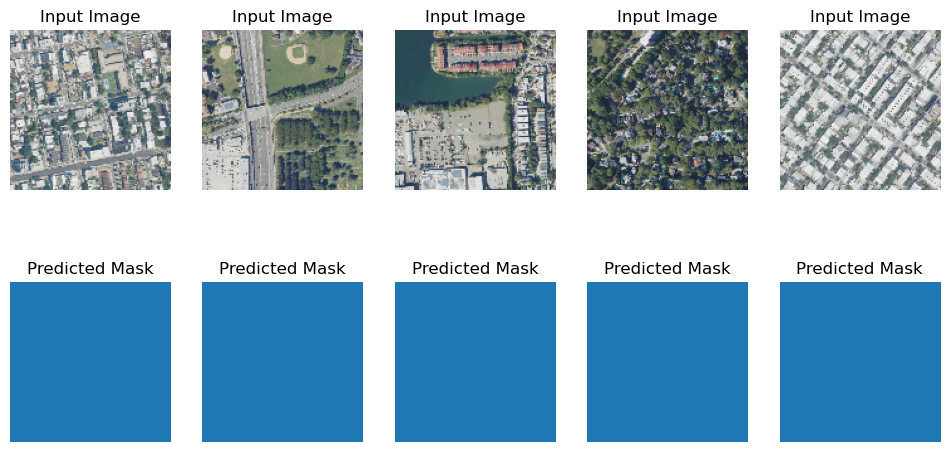

Model Accuracy on Test Set: 44.4749


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, device, test_loader, num_visualizations=5):
    model.eval()
    running_corrects = 0
    total_pixels = 0
    visualized_samples = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Calculate accuracy
            running_corrects += torch.sum(preds == masks)
            total_pixels += masks.nelement()

            # Visualization logic
            if visualized_samples < num_visualizations:
                plt.figure(figsize=(12, 6))
                for idx in range(images.size(0)):
                    if visualized_samples >= num_visualizations:
                        break
                    plt.subplot(2, num_visualizations, visualized_samples + 1)
                    img = images[idx].cpu().permute(1, 2, 0)
                    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                    plt.imshow(img.clip(0, 1))
                    plt.title("Input Image")
                    plt.axis("off")

                    plt.subplot(2, num_visualizations, num_visualizations + visualized_samples + 1)
                    plt.imshow(preds[idx].cpu(), cmap='tab20', interpolation='nearest')
                    plt.title("Predicted Mask")
                    plt.axis("off")

                    visualized_samples += 1
                plt.show()

    # Calculate and print overall accuracy
    accuracy = running_corrects.double() / total_pixels
    print(f"Model Accuracy on Test Set: {accuracy:.4f}")

# Call the evaluation function
evaluate_and_visualize(model, device, test_loader)
